# Model 3a:

Batched Draupnir Model (Unaligned)


Model details:

|Flavor|Included or Not|
|:---------:|:-----:|
|Unaligned Sequences|×|
|Latent Tree| |
|Batched Input|×|




In [ ]:
leaf_seq_path = "/content/realign_MSA.fas"
ancestor_path = "/content/_pep_Unaligned_Internal_Nodes.FASTA"
tree_path = "/content/_True_Rooted_tree_node_labels.tre"

In [ ]:
! pip install pyro-ppl
! pip install Biopython

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import math

from ASR import ASR

In [ ]:
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [ ]:
batch_size = 64

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S, S_names, S_lengths, S_char = load_Unaligned_Data(leaf_seq_path, "cuda", AA_dict)

_, Anc_names, Anc_lengths, Anc_char = load_Unaligned_Data(ancestor_path, "cuda", AA_dict)
Anc_names[Anc_names.index("Node1 The root")] = "Node1"

In [ ]:
msa_ref = torch.rand(int(S.shape[1] * 1.5), 23, device="cuda")

In [ ]:
def get_true_tree_distances_including_ancestors(true_tree_path, S_names, ancestor_names):
    """
    Only work for simulation data
    Since the names of simulated ancestors are just numbers, Biopython will interpret them as "confidence" by default
    And there is no name/confidence for root

    """
    t = Phylo.read(true_tree_path, "newick")
    nodes = t.get_terminals() + t.get_nonterminals()
    mat = np.zeros([len(nodes), len(nodes)])
    names = S_names + ancestor_names

    for x, y in tqdm(itertools.combinations(nodes, 2)):
        v = t.distance(x, y)
        x_name = "Node" + str(x.confidence) if x.confidence is not None else "Node1" if x.name is None else x.name
        y_name = "Node" + str(y.confidence) if y.confidence is not None else "Node1" if y.name is None else y.name
        idx, idy = names.index(x_name), names.index(y_name)
        mat[idx][idy] = v
        mat[idy][idx] = v
    return mat

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

In [ ]:
true_tree_distances_including_ancestors.shape, true_tree_distances.shape

((2047, 2047), (1024, 1024))

In [ ]:
pyro.clear_param_store()
vae = VAE(50, 24, msa_ref.shape[0])

In [ ]:
def per_param_callable(module_name, param_name):
    if param_name in ["Blosum"]:
        return {"lr": 1e-8, "clip_norm": 10}
    else:   
        return {"lr": 0.0015, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.batched_model, vae.batched_guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []

S_ave_pos = []

Rec_Acc = []
Rec_Acc_remove_gap = []

In [ ]:
for b in tqdm(range(1001)):

    indices = np.random.choice(S.shape[0], S.shape[0], False)
    elbos = []
    for batch in range(S.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])
      elbo = svi.step(Unaligned_S=S[batch_idx],
               S_length=list(np.array(S_lengths)[batch_idx]),
               msa_ref=msa_ref,
               batch_distance=torch.from_numpy(true_tree_distances[all_idx][:, all_idx]).float().to(vae.device), 
               S_ave_pos=S_ave_pos,
               num_batch=S.shape[0] // batch_size - 1,
               Unaligned_S_back=S[back_idx],
               S_back_length=list(np.array(S_lengths)[back_idx]))

      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))

    msa_ref_epoch = torch.cat(S_ave_pos, dim=0).sum(dim=0) + 1e-3
    msa_ref_epoch /= msa_ref_epoch.sum(-1, True)

    msa_ref = msa_ref_epoch * 0.05 + msa_ref * 0.95
    S_ave_pos = [] # clear


    if b == 500:
        def per_param_callable(module_name, param_name):
            return {"lr": 0.0015, "clip_norm": 10}
        optimizer = pyro.optim.ClippedAdam(per_param_callable)
        svi = SVI(vae.batched_model, vae.batched_guide, optimizer, loss=Trace_ELBO(num_particles=1))


    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S[:, :, None], 1)
            S_onehot = S_onehot[:, :, :].float().cuda()
            ref_emb = msa_ref
            mask = (torch.arange(S.shape[1])[None, :] < torch.tensor(S_lengths)[:, None]).to(vae.device)
            s_emb = (S_onehot * mask[:, :, None])[:, :, :-1]
            similar_tensor = ref_emb @ pyro.param("Blosum") @ s_emb.transpose(1, 2)


            path = torch.cat([snw(similar_tensor[i * batch_size: (i + 1) * batch_size], list(S_lengths)[i * batch_size: (i + 1) * batch_size], vae.nw_fn) for i in range(int(math.ceil(S.shape[0] / batch_size)))], dim=0)

            MSA = path @ S_onehot  # N, L, l @ N, l, n_c
            MSA[:, :, -1] = MSA[:, :, -1] + 1 - path.sum(-1)  # fill the gaps with onehot-encoding of "-"

            Z_loc = vae.encoder(MSA, S_lengths).detach()
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=False)))

with torch.no_grad():       
    # Distances Correlation
    latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
    latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
    latent_distance_upper = latent_distance[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    real_distance_upper = true_tree_distances[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    Spearmans = spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0]
    Pearsons = pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0]

    # ASR ACC
    sigma_f = pyro.param("sigma_f_loc")
    sigma_n = pyro.param("sigma_n_loc")
    lambd = pyro.param("lambd_loc")

    cov = torch.from_numpy(true_tree_distances_including_ancestors).to(vae.device).float()[np.newaxis, :, :].expand([vae.n_z, true_tree_distances_including_ancestors.shape[0], true_tree_distances_including_ancestors.shape[0]]) / lambd[:, np.newaxis, np.newaxis]
    cov = (torch.exp(-cov) * sigma_f[:, np.newaxis, np.newaxis] ** 2 + torch.eye(cov.shape[1], device=vae.device)[np.newaxis, :, :] * sigma_n[:, np.newaxis, np.newaxis] ** 2)

    cov_tips = cov[:, :len(S_names), :len(S_names)]
    cov_anc = cov[:, len(S_names):, len(S_names):]
    con_tips_anc = cov[:, len(S_names):, :len(S_names)]

    rec_anc = ASR(Z_loc, cov_tips, cov_anc, con_tips_anc, decoder=lambda x: vae.decoder(None, x, False))
    rec_anc = tensor2char(rec_anc, back_AA_dict)

    # LCA ASR ACC
    t = Phylo.read(tree_path, "newick")
    tips = t.get_terminals()
    ground = []
    predicts = []
    for i in tqdm(range(len(tips))):
        for j in range(i+1, len(tips)):
            lca = t.common_ancestor(tips[i], tips[j])
            lca_name = "Node" + str(lca.confidence) if lca.confidence is not None else "Node1" 
            lca_index = Anc_names.index(lca_name)
            ground.append(Anc_char[lca_index])
            predicts.append(rec_anc[lca_index])
    accs = asr_accuracy(ground, predicts)
    LCA_ASR_Acc = np.mean(accs)
    LCA_ASR_Acc_std = np.std(accs)
    LCA_ASR_Acc_max = np.max(accs)
    LCA_ASR_Acc_min = np.min(accs)

100%|██████████| 1024/1024 [07:14<00:00,  2.36it/s]


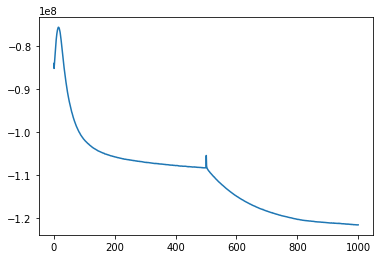

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

0.8699893055736834


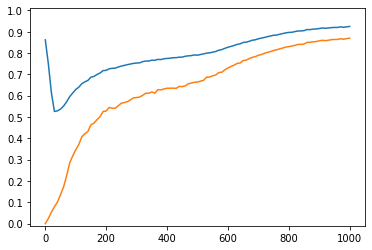

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.plot(np.arange(len(Rec_Acc_remove_gap)) * 10, Rec_Acc_remove_gap)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))
print(max(Rec_Acc_remove_gap[1:]))

In [ ]:
print(Spearmans, Pearsons)

0.4559393723959155 0.6193574067192423


In [ ]:
LCA_ASR_Acc, LCA_ASR_Acc_std, LCA_ASR_Acc_max, LCA_ASR_Acc_min

(0.7839244209941628, 0.019362921026422283, 0.93, 0.6718266253869969)